# Noise Suppression using deep learning



#Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Extracting Data

In [ ]:
!mkdir "CleanData"
!mkdir "NoisyData"
!unzip "/content/drive/MyDrive/Minor dataset/DataSet_1000/clean.zip" -d "CleanData"
!unzip "/content/drive/MyDrive/Minor dataset/DataSet_1000/noisy.zip" -d "NoisyData"


# !unzip "/content/drive/MyDrive/Minor dataset/clean_trainset_wav.zip" -d "CleanData"
# !unzip "/content/drive/MyDrive/Minor dataset/noisy_trainset_wav.zip" -d "NoisyData"

# !unzip "/content/drive/MyDrive/Minor dataset/6000/clean.zip" -d "CleanData"
# !unzip "/content/drive/MyDrive/Minor dataset/6000/noisy.zip" -d "NoisyData"

Archive:  /content/drive/MyDrive/Minor dataset/DataSet_1000/clean.zip
  inflating: CleanData/p226_001.wav  
  inflating: CleanData/p226_002.wav  
  inflating: CleanData/p226_003.wav  
  inflating: CleanData/p226_004.wav  
  inflating: CleanData/p226_005.wav  
  inflating: CleanData/p226_006.wav  
  inflating: CleanData/p226_007.wav  
  inflating: CleanData/p226_008.wav  
  inflating: CleanData/p226_009.wav  
  inflating: CleanData/p226_010.wav  
  inflating: CleanData/p226_011.wav  
  inflating: CleanData/p226_012.wav  
  inflating: CleanData/p226_013.wav  
  inflating: CleanData/p226_014.wav  
  inflating: CleanData/p226_015.wav  
  inflating: CleanData/p226_016.wav  
  inflating: CleanData/p226_017.wav  
  inflating: CleanData/p226_018.wav  
  inflating: CleanData/p226_019.wav  
  inflating: CleanData/p226_020.wav  
  inflating: CleanData/p226_021.wav  
  inflating: CleanData/p226_022.wav  
  inflating: CleanData/p226_023.wav  
  inflating: CleanData/p226_024.wav  
  inflating: Clean

In [ ]:
#test set consisting of 824 audio files in wav format

!mkdir "CleanTest"
!mkdir "NoisyTest"
!unzip "/content/drive/MyDrive/Minor dataset/clean_test.zip" -d "CleanTest"
!unzip "/content/drive/MyDrive/Minor dataset/noisy_test.zip" -d "NoisyTest"

Archive:  /content/drive/MyDrive/Minor dataset/clean_test.zip
  inflating: CleanTest/p232_001.wav  
  inflating: CleanTest/p232_002.wav  
  inflating: CleanTest/p232_003.wav  
  inflating: CleanTest/p232_005.wav  
  inflating: CleanTest/p232_006.wav  
  inflating: CleanTest/p232_007.wav  
  inflating: CleanTest/p232_009.wav  
  inflating: CleanTest/p232_010.wav  
  inflating: CleanTest/p232_011.wav  
  inflating: CleanTest/p232_012.wav  
  inflating: CleanTest/p232_013.wav  
  inflating: CleanTest/p232_014.wav  
  inflating: CleanTest/p232_015.wav  
  inflating: CleanTest/p232_016.wav  
  inflating: CleanTest/p232_017.wav  
  inflating: CleanTest/p232_019.wav  
  inflating: CleanTest/p232_020.wav  
  inflating: CleanTest/p232_021.wav  
  inflating: CleanTest/p232_022.wav  
  inflating: CleanTest/p232_023.wav  
  inflating: CleanTest/p232_024.wav  
  inflating: CleanTest/p232_025.wav  
  inflating: CleanTest/p232_027.wav  
  inflating: CleanTest/p232_028.wav  
  inflating: CleanTest/p23

#Load the Data

In [ ]:
clean_sounds = glob.glob('/content/CleanData/*')
noisy_sounds = glob.glob('/content/NoisyData/*')

clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

clean_sounds_list.shape,noisy_sounds_list.shape

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

(TensorShape([51252012, 1]), TensorShape([51252012, 1]))

In [ ]:
clean_test_sounds = glob.glob('/content/CleanTest/*')
noisy_test_sounds = glob.glob('/content/NoisyTest/*')

clean_sounds_list1,_ = tf.audio.decode_wav(tf.io.read_file(clean_test_sounds[0]),desired_channels=1)
for i in tqdm(clean_test_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list1 = tf.concat((clean_sounds_list1,so),0)

noisy_sounds_list1,_ = tf.audio.decode_wav(tf.io.read_file(noisy_test_sounds[0]),desired_channels=1)
for i in tqdm(noisy_test_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list1 = tf.concat((noisy_sounds_list1,so),0)

clean_sounds_list1.shape,noisy_sounds_list1.shape

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

(TensorShape([99457462, 1]), TensorShape([99457462, 1]))

In [ ]:
batching_size = 12000

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

clean_train.shape,noisy_train.shape

  0%|          | 0/4271 [00:00<?, ?it/s]

(TensorShape([4271, 12000, 1]), TensorShape([4271, 12000, 1]))

In [ ]:
clean_test,noisy_test = [],[]

for i in tqdm(range(0,clean_sounds_list1.shape[0]-batching_size,batching_size)):
  clean_test.append(clean_sounds_list1[i:i+batching_size])
  noisy_test.append(noisy_sounds_list1[i:i+batching_size])

clean_test = tf.stack(clean_test)
noisy_test = tf.stack(noisy_test)

clean_train.shape,noisy_train.shape

  0%|          | 0/8288 [00:00<?, ?it/s]

(TensorShape([4271, 12000, 1]), TensorShape([4271, 12000, 1]))

# Create a tf.data.Dataset

In [ ]:
def get_dataset(x_train,y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
  return dataset

In [ ]:
train_dataset = get_dataset(noisy_train,clean_train)
test_dataset = get_dataset(noisy_test,clean_test)

# train_dataset = get_dataset(noisy_train[:40000],clean_train[:40000])
# test_dataset = get_dataset(noisy_train[40000:],clean_train[40000:])

In [ ]:
def get_audio(path):
  audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
  return audio

In [ ]:
#SNR

import seaborn as sn
from scipy.stats import norm
import scipy.signal as sig
import copy

sn.set_theme()

In [ ]:
def signalPower(x):
    return np.average(x**2)

In [ ]:
def SNRsystem(inputSig, outputSig):
    noise = outputSig-inputSig
    
    powS = signalPower(outputSig)
    powN = signalPower(noise)
    return 10*np.log10((powS-powN)/powN)

#Reviewing Sample Waveform

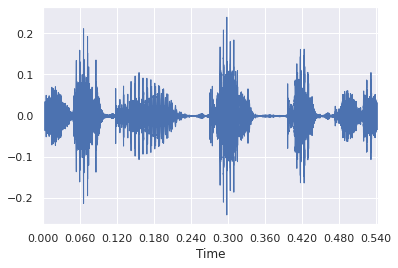

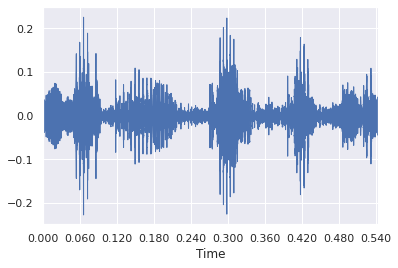

In [ ]:
librosa.display.waveplot(np.squeeze(clean_train[900].numpy(),axis=-1))
plt.show()
librosa.display.waveplot(np.squeeze(noisy_train[900].numpy(),axis=-1))
plt.show()

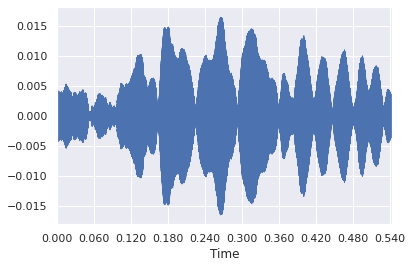

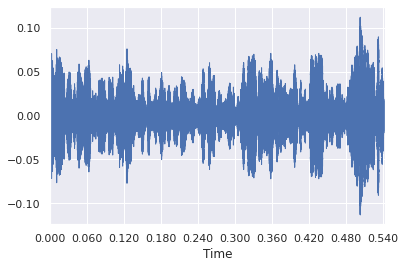

In [ ]:
librosa.display.waveplot(np.squeeze(clean_test[900].numpy(),axis=-1))
plt.show()
librosa.display.waveplot(np.squeeze(noisy_test[900].numpy(),axis=-1))
plt.show()

#Creating the Model

In [ ]:
inp = Input(shape=(batching_size,1))
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)
model = tf.keras.models.Model(inp,dc7)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6000, 2)      66          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3000, 4)      260         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1500, 8)      1032        ['conv1d_1[0][0]']               
                                                                                              

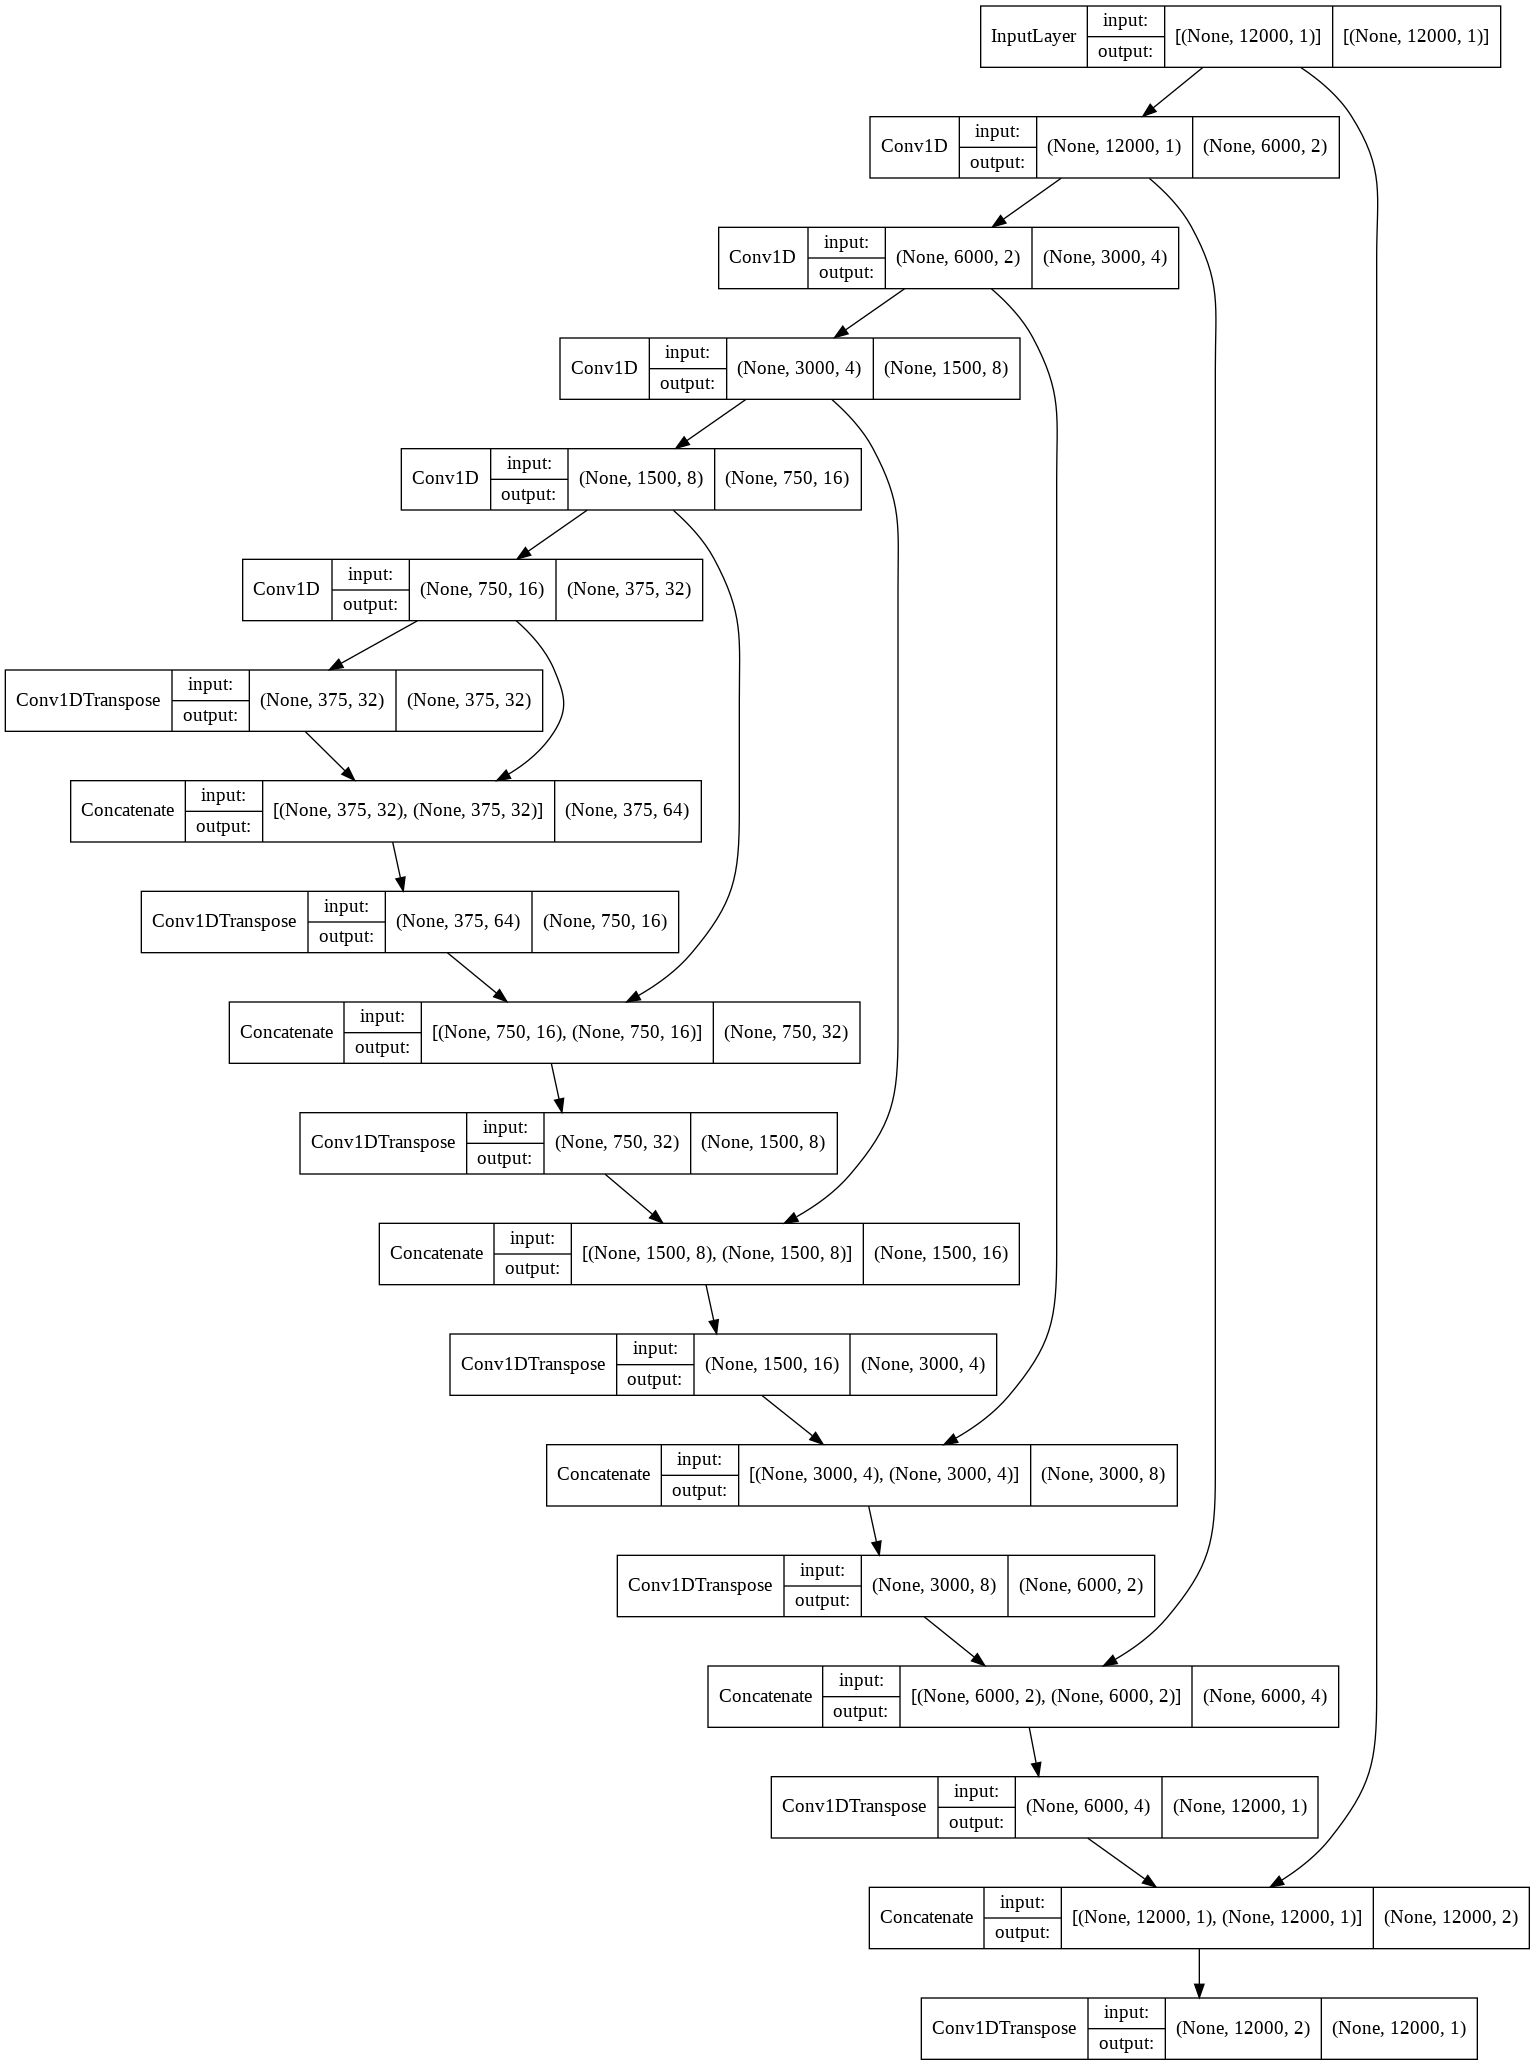

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

#Training

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.002),loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(train_dataset,epochs=20,validation_data = (test_dataset))

Epoch 1/20
66/66 [==============================] - 18s 85ms/step - loss: 0.0216 - val_loss: 0.0224
Epoch 2/20
66/66 [==============================] - 5s 78ms/step - loss: 0.0175 - val_loss: 0.0224
Epoch 3/20
66/66 [==============================] - 5s 80ms/step - loss: 0.0162 - val_loss: 0.0231
Epoch 4/20
66/66 [==============================] - 5s 79ms/step - loss: 0.0156 - val_loss: 0.0234
Epoch 5/20
66/66 [==============================] - 5s 78ms/step - loss: 0.0151 - val_loss: 0.0250
Epoch 6/20
66/66 [==============================] - 5s 79ms/step - loss: 0.0147 - val_loss: 0.0251
Epoch 7/20
66/66 [==============================] - 5s 78ms/step - loss: 0.0144 - val_loss: 0.0234
Epoch 8/20
66/66 [==============================] - 5s 80ms/step - loss: 0.0144 - val_loss: 0.0244
Epoch 9/20
66/66 [==============================] - 5s 81ms/step - loss: 0.0140 - val_loss: 0.0268
Epoch 10/20
66/66 [==============================] - 5s 80ms/step - loss: 0.0138 - val_loss: 0.0243
Epoch 11

#Testing Samples

In [ ]:

Audio(np.squeeze(noisy_train[4].numpy()),rate=16000)

In [ ]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[4],-1),0))),rate=16000)

In [ ]:
score = model.evaluate(test_dataset)
print('Test loss:', score)


129/129 [==============================] - 3s 19ms/step - loss: 0.0271
Test loss: 0.027080032974481583


In [ ]:
model.save('NoiseSuppressionModel.h5')

# Inference

Handling different sized audio inputs can be solved by overlapping prediction frames and removing the intersection part from the final waveform

In [ ]:
def get_audio(path):
  audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
  return audio

In [ ]:
def inference_preprocess(path):
  audio = get_audio(path)
  audio_len = audio.shape[0]
  batches = []
  for i in range(0,audio_len-batching_size,batching_size):
    batches.append(audio[i:i+batching_size])

  batches.append(audio[-batching_size:])
  diff = audio_len - (i + batching_size)
  return tf.stack(batches), diff

In [ ]:
def predict(path):
  test_data,diff = inference_preprocess(path)
  predictions = model.predict(test_data)
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((final_op,predictions[-1][-diff:]),axis=0)
  return final_op

In [ ]:
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
Audio(tf.squeeze(predict(noisy_sounds[4])),rate=16000)

In [ ]:
%%timeit
tf.squeeze(predict(noisy_sounds[3]))

10 loops, best of 5: 49.3 ms per loop


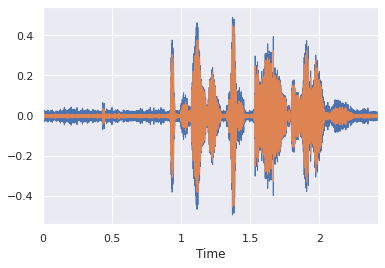

In [ ]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[4])))

#Quantization and TFLite Conversion

In [ ]:
lite_model = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = lite_model.convert()

INFO:tensorflow:Assets written to: /tmp/tmpmjsovl3d/assets


In [ ]:
with open('TFLiteModel.tflite','wb') as f:
  f.write(tflite_model_quant)

#TFLite Inference

In [ ]:
interpreter = tf.lite.Interpreter(model_path='/content/TFLiteModel.tflite')
interpreter.allocate_tensors()

In [ ]:
def predict_tflite(path):
  test_audio,diff = inference_preprocess(path)
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  preds = []
  for i in test_audio:
    interpreter.set_tensor(input_index, tf.expand_dims(i,0))
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    preds.append(predictions)

  predictions = tf.squeeze(tf.stack(preds,axis=1))
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((tf.squeeze(final_op),predictions[-1][-diff:]),axis=0)
  return final_op

In [ ]:
# Original Noisy Audio
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
# Clean Audio
Audio(np.squeeze(get_audio(clean_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
# Output Audio
Audio(predict_tflite(noisy_sounds[4]),rate=16000)

In [ ]:
%%timeit
predict_tflite(noisy_sounds[4])

1 loop, best of 5: 209 ms per loop


In [ ]:
Audio(np.squeeze(get_audio(noisy_test_sounds[10]).numpy(),-1),rate=48000)

In [ ]:
Audio(np.squeeze(get_audio(clean_test_sounds[10]).numpy(),-1),rate=48000)

In [ ]:
# Output Audio
Audio(predict_tflite(noisy_test_sounds[10]),rate=48000)

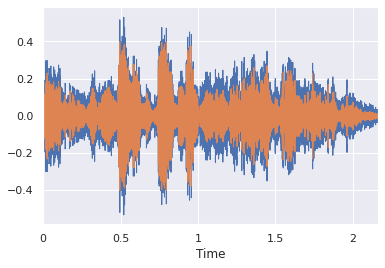

In [ ]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[300]).numpy(),-1))
librosa.display.waveplot(predict_tflite(noisy_sounds[300]).numpy())

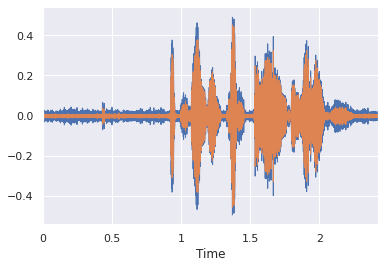

In [ ]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveplot(predict_tflite(noisy_sounds[4]).numpy())

In [ ]:
for i in range(0,999):
  
  c_signal=np.squeeze(get_audio(clean_sounds[i]).numpy(),-1)
  n_signal=np.squeeze(get_audio(noisy_sounds[i]).numpy(),-1)
  p_signal=np.squeeze(predict_tflite(noisy_sounds[i]).numpy())
  
  method1 = SNRsystem(c_signal,n_signal)
  method2 = SNRsystem(c_signal,p_signal)
  print(i,"    Orginal noise : {:.1f} dB  ;   Suppressed noise : {:.1f} dB".format(method1,method2))


0     Orginal noise : 8.3 dB  ;   Suppressed noise : 10.2 dB
1     Orginal noise : 3.4 dB  ;   Suppressed noise : 5.2 dB
2     Orginal noise : 3.7 dB  ;   Suppressed noise : 7.6 dB
3     Orginal noise : 9.0 dB  ;   Suppressed noise : 10.3 dB
4     Orginal noise : 12.9 dB  ;   Suppressed noise : 10.9 dB
5     Orginal noise : -2.0 dB  ;   Suppressed noise : 8.5 dB
6     Orginal noise : -1.1 dB  ;   Suppressed noise : 10.8 dB
7     Orginal noise : 13.3 dB  ;   Suppressed noise : 9.9 dB
8     Orginal noise : -1.3 dB  ;   Suppressed noise : 5.8 dB
9     Orginal noise : 3.5 dB  ;   Suppressed noise : 6.2 dB
10     Orginal noise : 8.8 dB  ;   Suppressed noise : 12.4 dB
11     Orginal noise : 3.2 dB  ;   Suppressed noise : 6.4 dB
12     Orginal noise : -1.5 dB  ;   Suppressed noise : 5.4 dB
13     Orginal noise : 8.8 dB  ;   Suppressed noise : 10.4 dB
14     Orginal noise : 8.7 dB  ;   Suppressed noise : 13.1 dB
15     Orginal noise : -0.7 dB  ;   Suppressed noise : 1.2 dB
16     Orginal noise

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


35     Orginal noise : -2.5 dB  ;   Suppressed noise : nan dB
36     Orginal noise : 8.6 dB  ;   Suppressed noise : 8.9 dB
37     Orginal noise : 9.1 dB  ;   Suppressed noise : 12.3 dB
38     Orginal noise : 14.0 dB  ;   Suppressed noise : 12.3 dB
39     Orginal noise : -1.7 dB  ;   Suppressed noise : 10.6 dB
40     Orginal noise : 13.0 dB  ;   Suppressed noise : 13.4 dB
41     Orginal noise : 3.9 dB  ;   Suppressed noise : 7.7 dB
42     Orginal noise : 12.9 dB  ;   Suppressed noise : 11.4 dB
43     Orginal noise : 13.2 dB  ;   Suppressed noise : 12.3 dB
44     Orginal noise : 13.6 dB  ;   Suppressed noise : 12.4 dB
45     Orginal noise : 12.3 dB  ;   Suppressed noise : 12.4 dB
46     Orginal noise : 2.2 dB  ;   Suppressed noise : 6.9 dB
47     Orginal noise : 13.1 dB  ;   Suppressed noise : 13.4 dB
48     Orginal noise : 13.2 dB  ;   Suppressed noise : 12.7 dB
49     Orginal noise : 13.3 dB  ;   Suppressed noise : 12.9 dB
50     Orginal noise : 12.5 dB  ;   Suppressed noise : 11.8 dB


In [ ]:
#for i in [9,45,127,342]:
for i in [421,256,188,651,246,54]:
  
  c_signal=np.squeeze(get_audio(clean_sounds[i]).numpy(),-1)
  n_signal=np.squeeze(get_audio(noisy_sounds[i]).numpy(),-1)
  p_signal=np.squeeze(predict_tflite(noisy_sounds[i]).numpy())
  
  method1 = SNRsystem(c_signal,n_signal)
  method2 = SNRsystem(c_signal,p_signal)
  print("Orginal noise : {:.1f} dB  ;   Suppressed noise : {:.1f} dB".format(method1,method2))

 

Orginal noise : 2.8 dB  ;   Suppressed noise : 4.5 dB
Orginal noise : 4.1 dB  ;   Suppressed noise : 12.1 dB
Orginal noise : 8.3 dB  ;   Suppressed noise : 13.0 dB
Orginal noise : 13.6 dB  ;   Suppressed noise : 15.3 dB
Orginal noise : 13.6 dB  ;   Suppressed noise : 12.7 dB
Orginal noise : 13.6 dB  ;   Suppressed noise : 13.6 dB


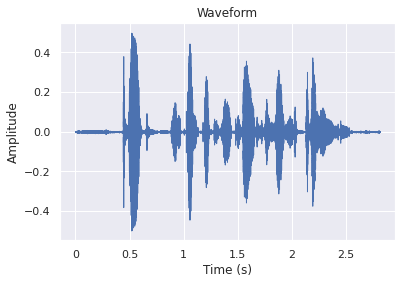

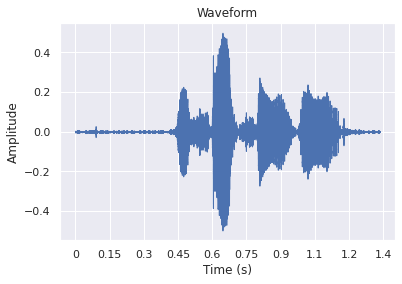

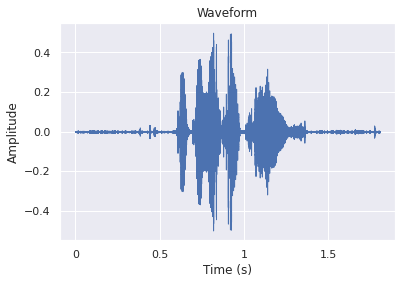

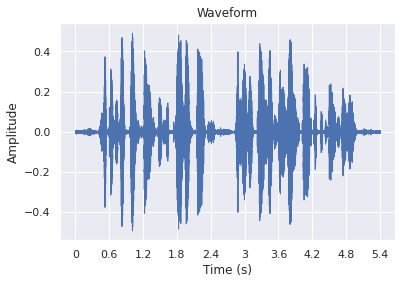

In [ ]:
sample_rate=48000
import librosa, librosa.display
import matplotlib.pyplot as plt
# FIG_SIZE = (15,10)

for i in [6,22,235,842]:
  
  librosa.display.waveshow(np.squeeze(get_audio(clean_sounds[i]).numpy(),-1))
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.title("Waveform")
  plt.show()

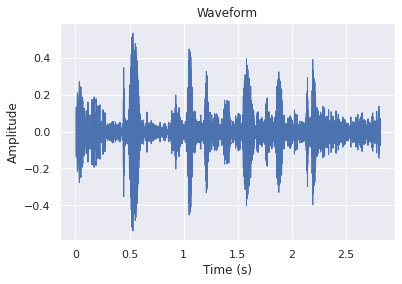

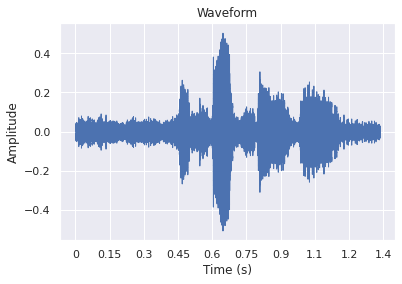

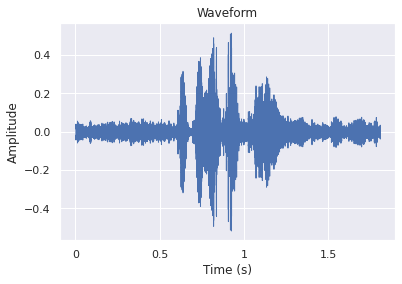

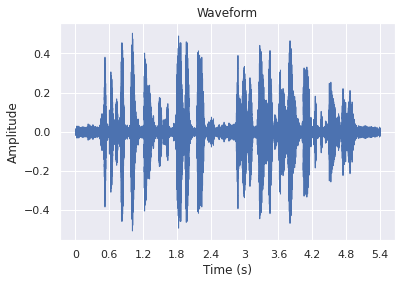

In [ ]:
import librosa, librosa.display
import matplotlib.pyplot as plt
# FIG_SIZE = (15,10)
# sample_rate=48000
for i in [6,22,235,842]:
  
  librosa.display.waveshow(np.squeeze(get_audio(noisy_sounds[i]).numpy(),-1))
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.title("Waveform")
  plt.show()

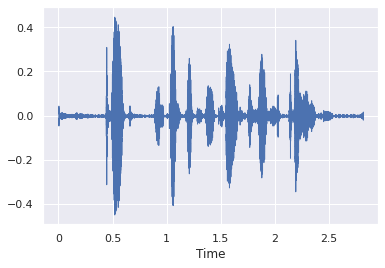

In [ ]:
librosa.display.waveshow(predict_tflite(noisy_sounds[6]).numpy())

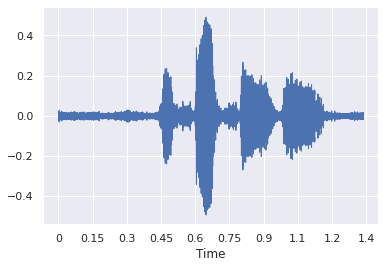

In [ ]:
librosa.display.waveshow(predict_tflite(noisy_sounds[22]).numpy())

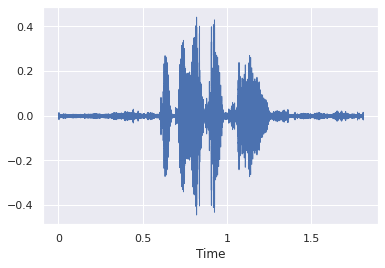

In [ ]:
librosa.display.waveshow(predict_tflite(noisy_sounds[235]).numpy())

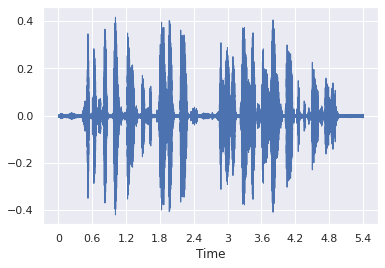

In [ ]:
librosa.display.waveshow(predict_tflite(noisy_sounds[842]).numpy())

In [ ]:
# predicted with noisy

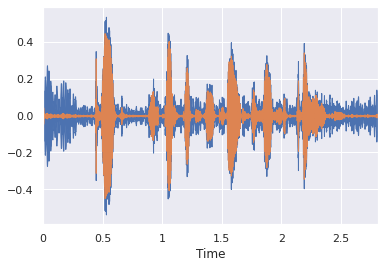

In [ ]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[6]).numpy(),-1))
librosa.display.waveplot(predict_tflite(noisy_sounds[6]).numpy())

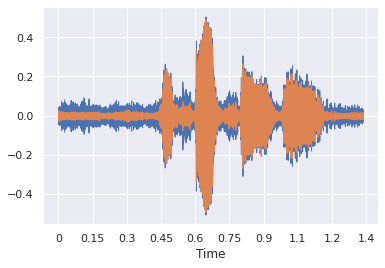

In [ ]:
librosa.display.waveshow(np.squeeze(get_audio(noisy_sounds[22]).numpy(),-1))
librosa.display.waveshow(predict_tflite(noisy_sounds[22]).numpy())

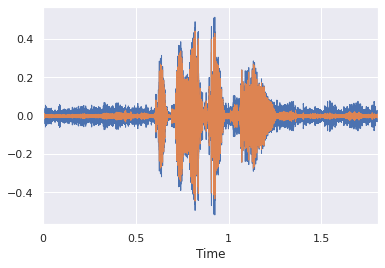

In [ ]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[235]).numpy(),-1))
librosa.display.waveplot(predict_tflite(noisy_sounds[235]).numpy())

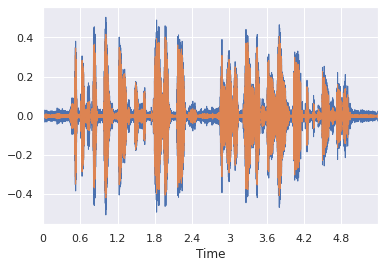

In [ ]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[842]).numpy(),-1))
librosa.display.waveplot(predict_tflite(noisy_sounds[842]).numpy())

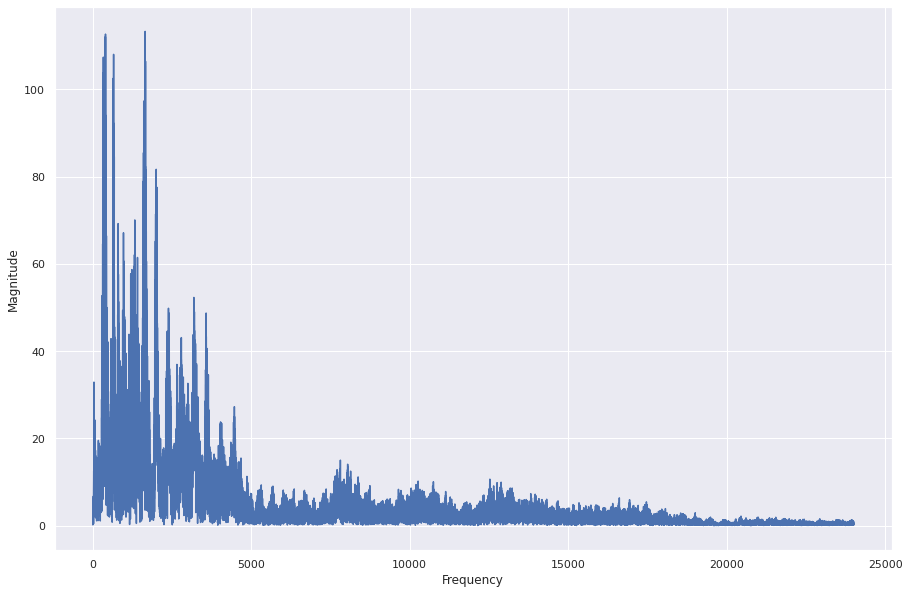

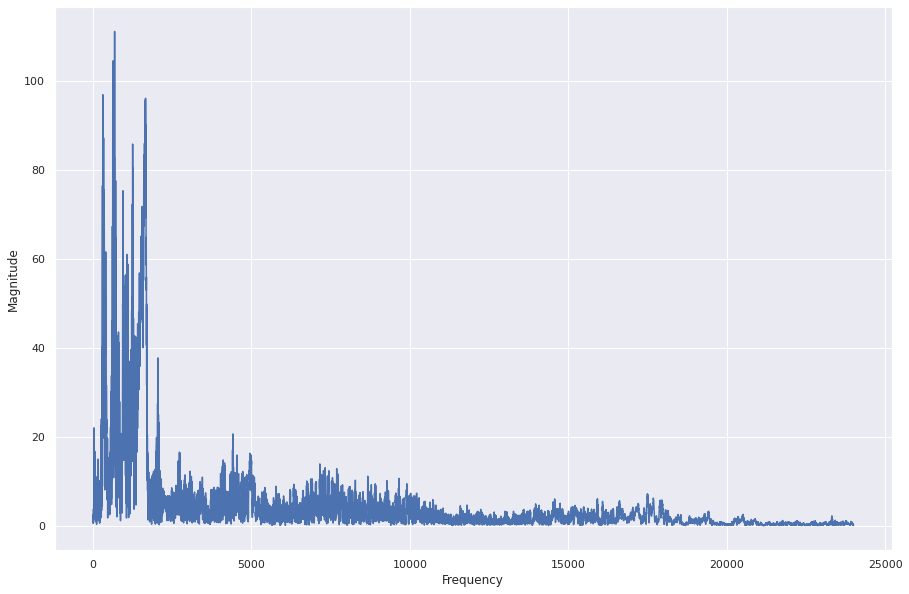

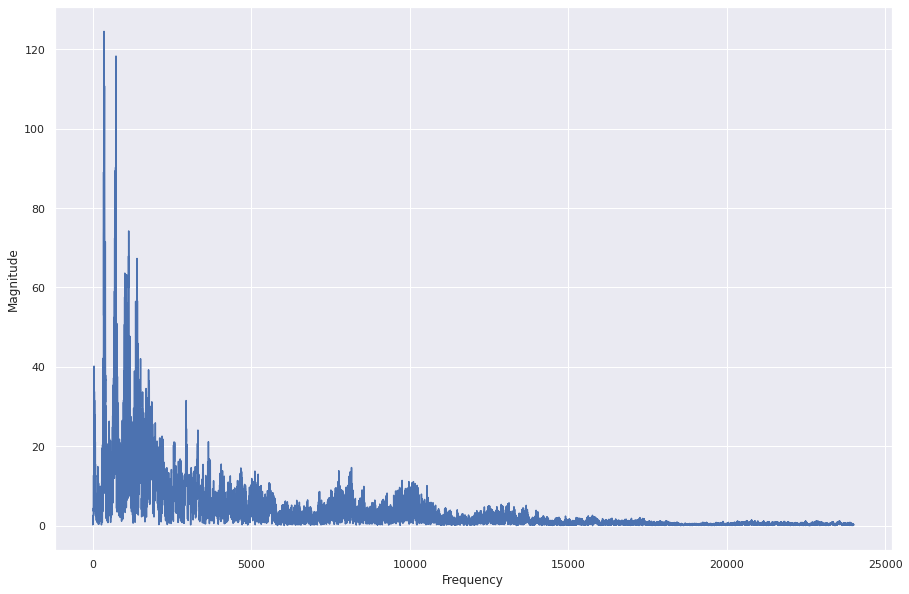

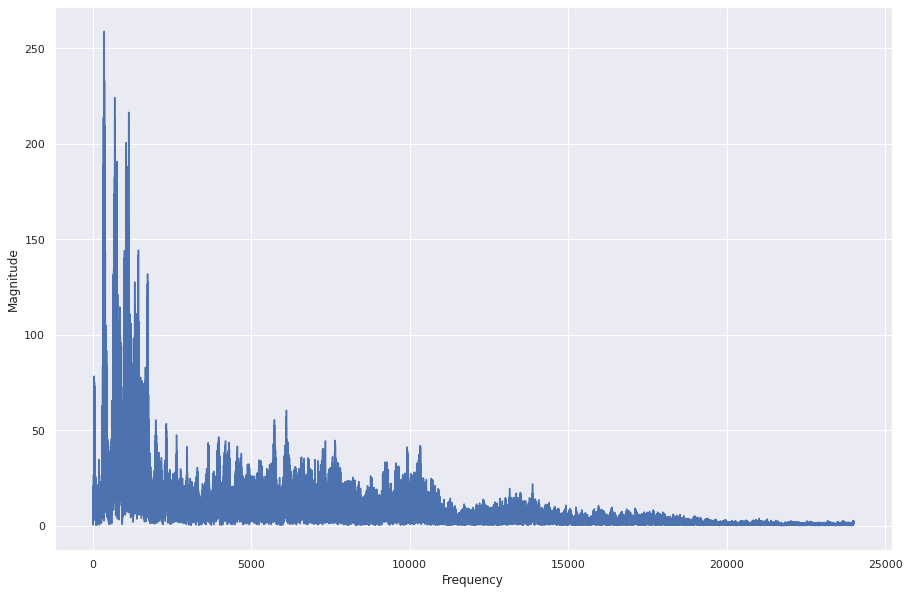

In [ ]:
FIG_SIZE = (15,10)
for i in [6,22,235,842]:
  # file1[i] = train_dataset[i]
  signal=np.squeeze(get_audio(clean_sounds[i]).numpy(),-1)
  # FFT -> power spectrum
  # perform Fourier transform
  fft = np.fft.fft(signal)

  # calculate abs values on complex numbers to get magnitude
  spectrum = np.abs(fft)

  # create frequency variable
  f = np.linspace(0, sample_rate, len(spectrum))

  # take half of the spectrum and frequency
  left_spectrum = spectrum[:int(len(spectrum)/2)]
  left_f = f[:int(len(spectrum)/2)]

  # plot spectrum
  plt.figure(figsize=FIG_SIZE)
  plt.plot(left_f, left_spectrum)
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  # plt.title("Power spectrum")
  plt.show()

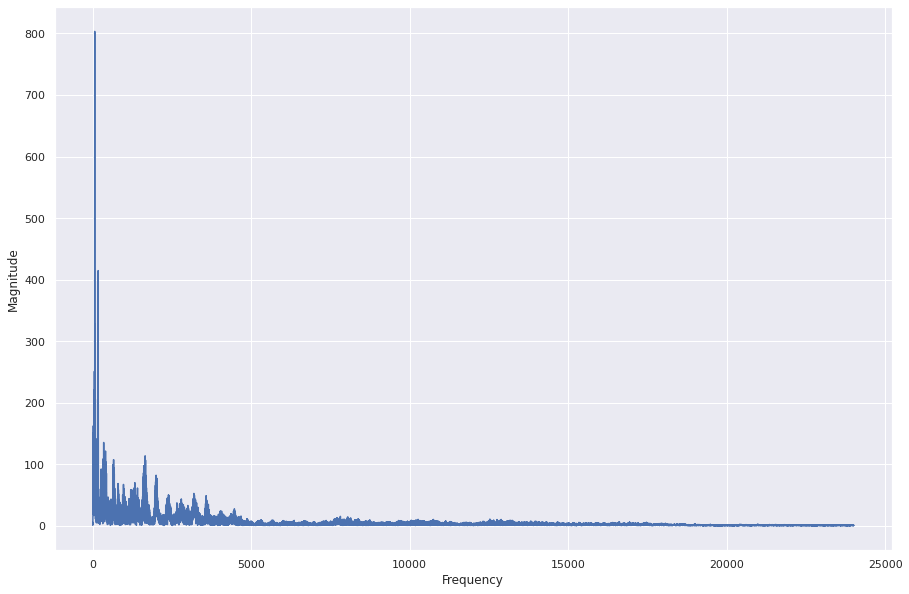

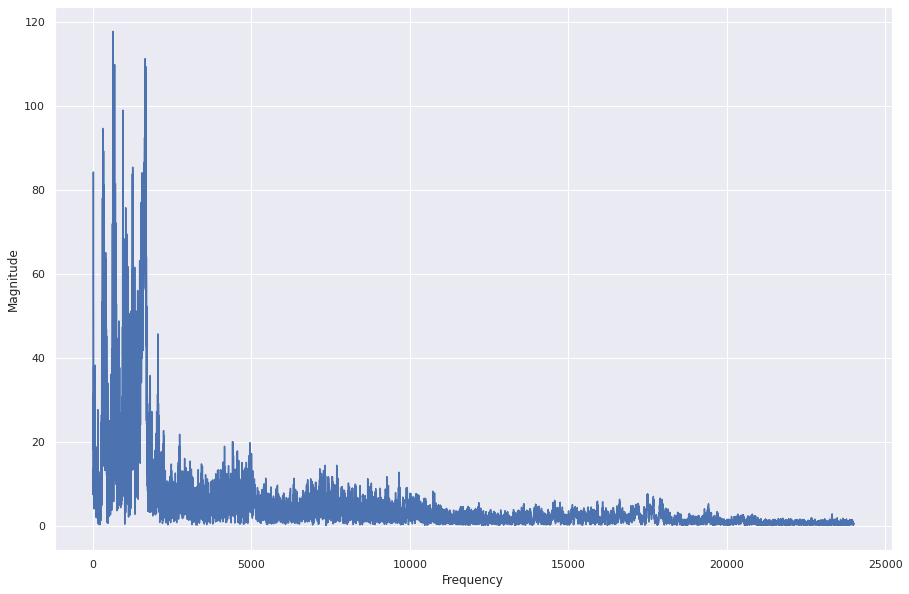

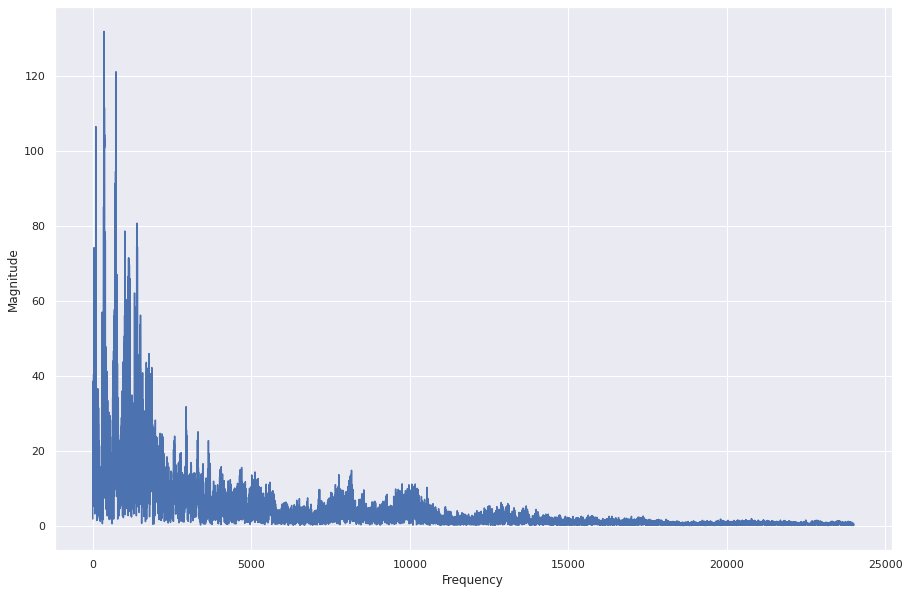

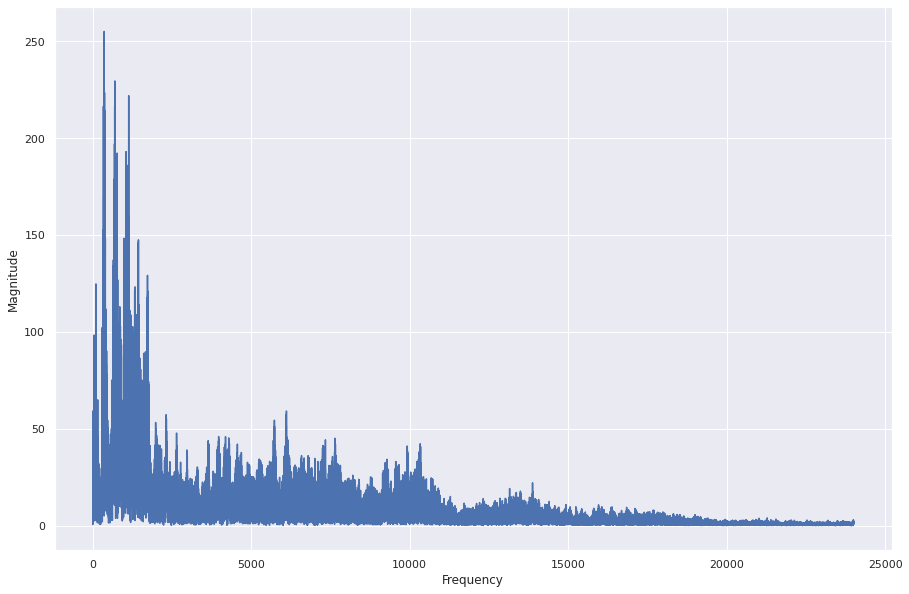

In [ ]:
FIG_SIZE = (15,10)
for i in [6,22,235,842]:
  # file1[i] = train_dataset[i]
  signal=np.squeeze(get_audio(noisy_sounds[i]).numpy(),-1)
  # FFT -> power spectrum
  # perform Fourier transform
  fft = np.fft.fft(signal)

  # calculate abs values on complex numbers to get magnitude
  spectrum = np.abs(fft)

  # create frequency variable
  f = np.linspace(0, sample_rate, len(spectrum))

  # take half of the spectrum and frequency
  left_spectrum = spectrum[:int(len(spectrum)/2)]
  left_f = f[:int(len(spectrum)/2)]

  # plot spectrum
  plt.figure(figsize=FIG_SIZE)
  plt.plot(left_f, left_spectrum)
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  # plt.title("Power spectrum")
  plt.show()

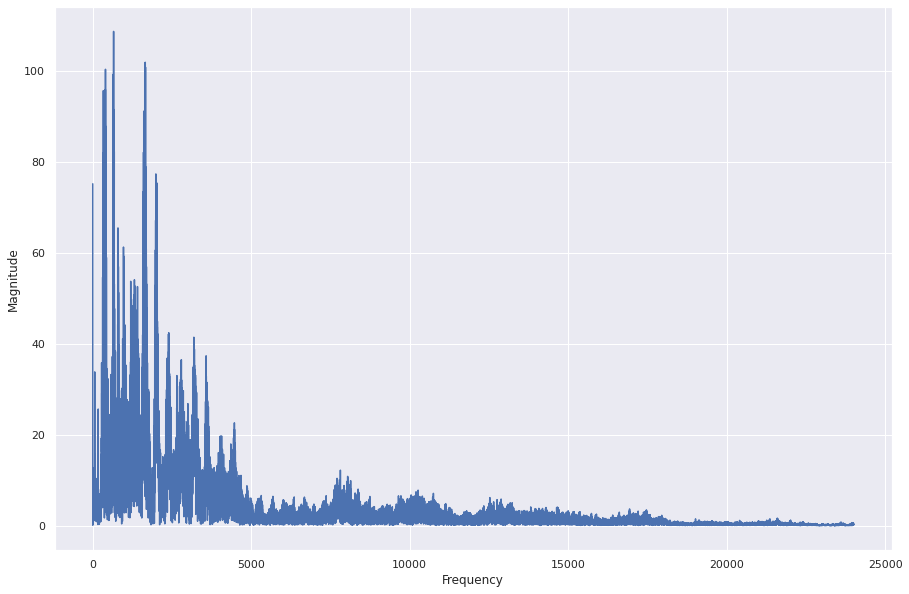

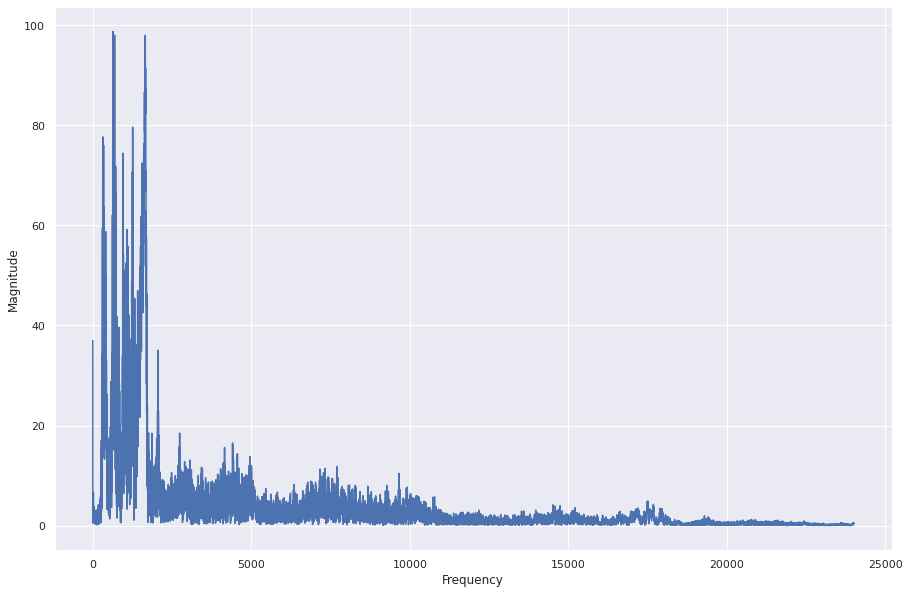

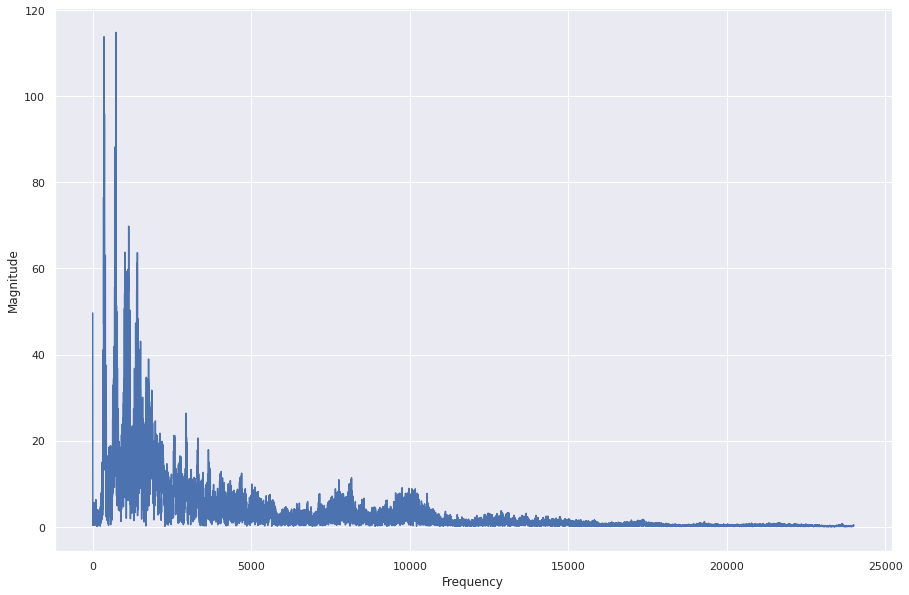

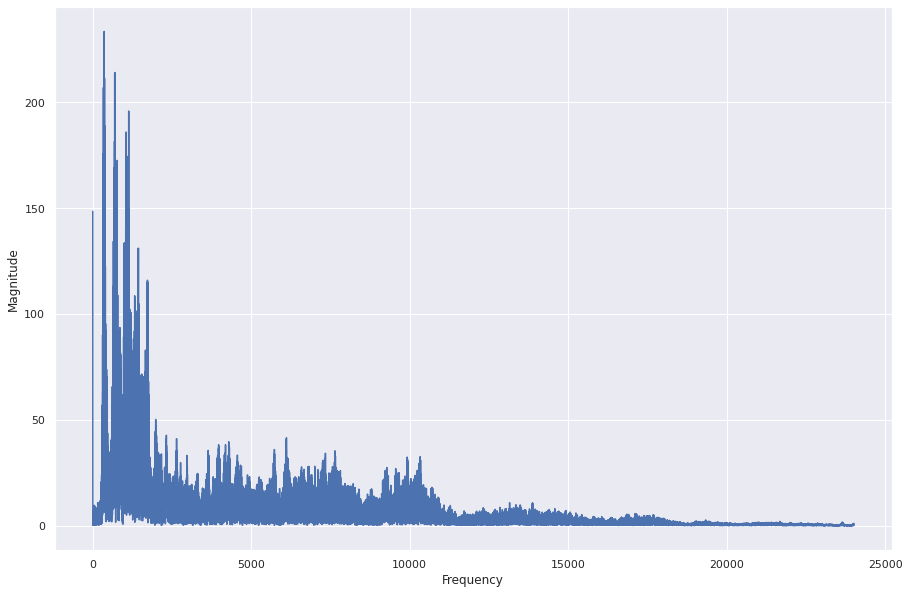

In [ ]:
#predicted
FIG_SIZE = (15,10)
for i in [6,22,235,842]:
  # file1[i] = train_dataset[i]
  signal= predict_tflite(noisy_sounds[i]).numpy()
  # FFT -> power spectrum
  # perform Fourier transform
  fft = np.fft.fft(signal)

  # calculate abs values on complex numbers to get magnitude
  spectrum = np.abs(fft)

  # create frequency variable
  f = np.linspace(0, sample_rate, len(spectrum))

  # take half of the spectrum and frequency
  left_spectrum = spectrum[:int(len(spectrum)/2)]
  left_f = f[:int(len(spectrum)/2)]

  # plot spectrum
  plt.figure(figsize=FIG_SIZE)
  plt.plot(left_f, left_spectrum)
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  # plt.title("Power spectrum")
  plt.show()

## Reference -  https://medium.com/analytics-vidhya/noise-suppression-using-deep-learning-6ead8c8a1839